# Tensorflow Input Pipeline Basics

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# conda create -n tf tensorflow
# conda activate tf
import tensorflow as tf

from termcolor import cprint

np.set_printoptions(precision=4)

cprint("Imported!", 'green')

Imported!


## Basic Mechanics

To create an input pipeline, we need a data source. For example, to construct a Dataset from data in memory, we can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`. Alternatively, if our input data is stored in a file in the recommended TFRecord format, we can use `tf.data.TFRecordDataset()`.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

The `dataset` object is a Python iterable object, so we can consume it in a for loop as seen below

In [ ]:
for elem in dataset:
    cprint(elem, 'cyan')

it = iter(dataset)
cprint(next(it).numpy(), 'blue')

### Dataset Structure
A dataset contains elements that each have the same (nested) structure and the individual components of the structure can be of any type representable by `tf.TypeSpec`, including `Tensor`, `SparseTensor`, `RaggedTensor`, `TensorArray`, or `Dataset`.

The `Dataset.element_spec` property allows you to inspect the type of each element component. The property returns a nested structure of `tf.TypeSpec` objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components. For example:

In [ ]:
dataset_1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset_1.element_spec


In [ ]:
dataset_2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset_2.element_spec

In [ ]:
dataset_3 = tf.data.Dataset.zip((dataset_1, dataset_2))

dataset_3.element_spec

In [ ]:
# Dataset containing a sparse tensor.
dataset_4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset_4.element_spec


In [ ]:
# Use value_type to see the type of value represented by the element spec
dataset_4.element_spec.value_type

The Dataset transformations support datasets of any structure. When using the `Dataset.map()`, and `Dataset.filter()` transformations, which apply a function to each element, the element structure determines the arguments of the function:

In [ ]:
dataset_1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

print(dataset_1)

for data in dataset_1:
    print(data.numpy())

## Reading Input Data

More information for specific situations can be found at the following links.

#### [Consuming NumPy arrays](https://www.tensorflow.org/guide/data#consuming_numpy_arrays)

#### [Consuming Python generators](https://www.tensorflow.org/guide/data#consuming_python_generators)

#### [Consuming TFRecord data](https://www.tensorflow.org/guide/data#consuming_tfrecord_data)

#### [Consuming text data](https://www.tensorflow.org/guide/data#consuming_text_data)

#### [Consuming CSV data](https://www.tensorflow.org/guide/data#consuming_csv_data)

#### [Consuming sets of files](https://www.tensorflow.org/guide/data#consuming_sets_of_files)

## Batching dataset elements

### Simple Batching
The simplest form of batching stacks n consecutive elements of a dataset into a single element. The `Dataset.batch()` transformation does exactly this, with the same constraints as the `tf.stack()` operator, applied to each component of the elements: i.e. for each component i, all elements must have a tensor of the exact same shape.



In [4]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

<RangeDataset shapes: (), types: tf.int64>
[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


While `tf.data` tries to propagate shape information, the default settings of `Dataset.batch` result in an unknown batch size because the last batch may not be full. Note the Nones in the shape:

In [5]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

Use the drop_remainder argument to ignore that last batch, and get full shape propagation:

In [6]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

### Batching Tensors with padding
The above recipe works for tensors that all have the same size. However, many models (e.g. sequence models) work with input data that can have varying size (e.g. sequences of different lengths). To handle this case, the `Dataset.padded_batch` transformation enables you to batch tensors of different shape by specifying one or more dimensions in which they may be padded.

In [7]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



The `Dataset.padded_batch` transformation allows you to set different padding for each dimension of each component, and it may be variable-length (signified by None in the example above) or constant-length. It is also possible to override the padding value, which defaults to 0.

## Training workflows
### Processing multiple epochs
The `tf.data` API offers two main ways to process multiple epochs of the same data.

The simplest way to iterate over a dataset in multiple epochs is to use the `Dataset.repeat()` transformation. First, create a dataset of titanic data:




In [8]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

32768/30874 [===============================] - 0s 0us/step


In [10]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

Applying the `Dataset.repeat()` transformation with no arguments will repeat the input indefinitely.

The `Dataset.repeat` transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batches that straddle epoch boundaries:

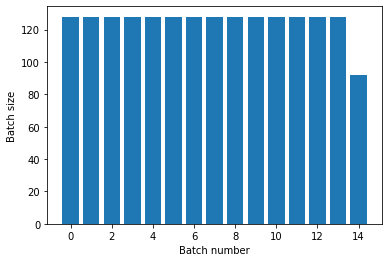

In [11]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

If you need clear epoch separation, put `Dataset.batch` before the repeat:

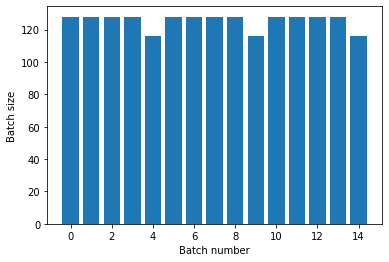

In [12]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [13]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### Randomly shuffling input data
The `Dataset.shuffle()` transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

> **Note**: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using [Dataset.interleave](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave) across files if this becomes a problem.

Add an index to the dataset so you can see the effect:


In [14]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.


In [15]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 76  22  87  20  13  68  85  65  72  95  53  84  34 106 107  59  97 109
  86  89]


As with `Dataset.batch` the order relative to `Dataset.repeat` matters.

`Dataset.shuffle` doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next:

In [16]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[627 618 612 587 534 411 547 576 535 568]
[595 408 520 623 610 557 600 551 174 545]
[554 579 487 516 585 552 476 571]
[ 12  18   3  42  59  40 105 100  31   5]
[95 81 66 96 79 85 27 65 93 58]


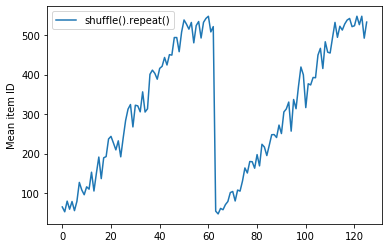

In [17]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

But a repeat before a shuffle mixes the epoch boundaries together:

In [18]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[592 543 513   6 540 596 478 601  14  17]
[550 427 619  22 535 559  24  23   7 622]
[603 604   2 617  27   5  42 498   1  39]
[340 499 408  53  21 614  13 598 503 579]
[569   8 602   4 560 545  40 477  37  66]
[582 107 580 616  71  54  56  35  33 613]
[627 511  80 589 522 624 389  61 520  50]
[ 86   3 585 595 472 391  30  48  36  62]
[ 73  90  94 515 404  18  97 102 100  92]
[494  72  69  25  67  93  29 118  84  91]
[597 546  57 583 593 541  34  15  98  83]
[ 45 623 610 575  26  78  43  52   9 607]
[275  46  41 128 115 103 134  81 608  55]
[120 138 496 142 124 150 137  85 109 117]
[157 121 130  20  74 158  32  49 161  89]


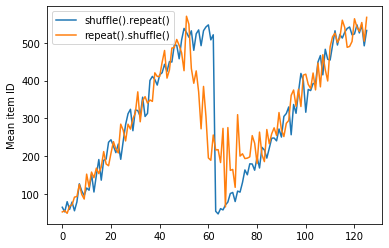

In [19]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Preprocessing data

The `Dataset.map(f)` transformation produces a new dataset by applying a given function `f` to each element of the input dataset. It is based on the `map()` function that is commonly applied to lists (and other structures) in functional programming languages. The function `f` takes the `tf.Tensor` objects that represent a single element in the input, and returns the `tf.Tensor` objects that will represent a single element in the new dataset. Its implementation uses standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use `Dataset.map()`.

### Decoding image data and resizing it
When training a neural network on real-world image data, it is often necessary to convert images of different sizes to a common size, so that they may be batched into a fixed size.

Rebuild the flower filenames dataset:


In [21]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

228818944/228813984 [==============================] - 18s 0us/step


Write a function that manipulates the dataset elements.

In [23]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, '/')
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

Test that it works.

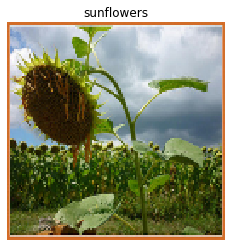

In [29]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

Map it over the dataset.

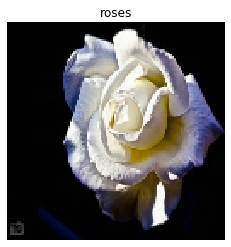

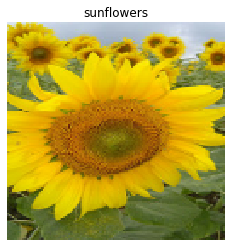

In [30]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### Applying arbitrary Python logic
For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the `tf.py_function()` operation in a `Dataset.map()` transformation.

For example, if you want to apply a random rotation, the `tf.image` module only has `tf.image.rot90`, which is not very useful for image augmentation.

> Note: `tensorflow_addons` has a TensorFlow compatible rotate in `tensorflow_addons.image.rotate`.

To demonstrate `tf.py_function`, try using the `scipy.ndimage.rotate` function instead:


In [31]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


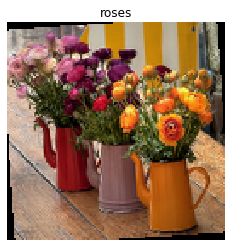

In [32]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

To use this function with `Dataset.map` the same caveats apply as with `Dataset.from_generator`, you need to describe the return shapes and types when you apply the function:

In [33]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


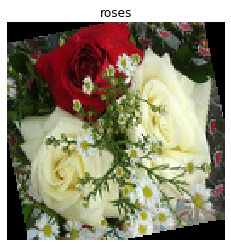

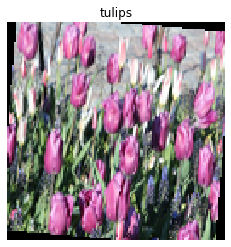

In [34]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### Parsing tf.Example protocol buffer messages
Many input pipelines extract `tf.train.Example` protocol buffer messages from a `TFRecord` format. Each `tf.train.Example` record contains one or more "features", and the input pipeline typically converts these features into tensors.


In [35]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

7905280/7904079 [==============================] - 1s 0us/step


<TFRecordDatasetV2 shapes: (), types: tf.string>

You can work with `tf.train.Example` protos outside of a `tf.data.Dataset` to understand the data:

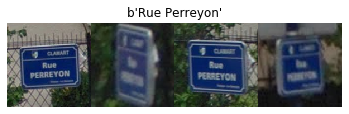

In [36]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [38]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [39]:
raw_example = next(iter(dataset))
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")


b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [40]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [41]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

### Time series windowing
For an end to end time series example see: [Time series forecasting](https://www.tensorflow.org/tutorials/text/time_series).

Time series data is often organized with the time axis intact.

Use a simple `Dataset.range` to demonstrate:


In [42]:
range_ds = tf.data.Dataset.range(100000)


Typically, models based on this sort of data will want a contiguous time slice.

The simplest approach would be to batch the data:

**Using batch**

In [43]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


Or to make dense predictions one step into the future, you might shift the features and labels by one step relative to each other:

In [44]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


To predict a whole window instead of a fixed offset you can split the batches into two parts:

In [45]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Take the first 5 steps
          batch[-5:])   # take the remainder

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


To allow some overlap between the features of one batch and the labels of another, use `Dataset.zip`:

In [46]:
feature_length = 10
label_length = 5

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:-5])

predict_5_steps = tf.data.Dataset.zip((features, labels))

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22 23 24]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32 33 34]


**Using window**
While using `Dataset.batch` works, there are situations where you may need finer control. The `Dataset.window` method gives you complete control, but requires some care: it returns a `Dataset` of `Datasets`. See [Dataset structure](https://www.tensorflow.org/guide/data#dataset_structure) for details.

In [47]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


The `Dataset.flat_map` method can take a dataset of datasets and flatten it into a single dataset:

In [48]:
 for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

Cause: could not parse the source code:

for x in windows.flat_map(lambda x: x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

for x in windows.flat_map(lambda x: x).take(30):

This error may be avoided by creating the lambda in a standalone statement.

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9

In nearly all cases, you will want to `.batch` the dataset first:

In [49]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


Now, you can see that the shift argument controls how much each window moves over.

Putting this together you might write this function:

In [50]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [51]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


Then it's easy to extract labels, as before:

In [52]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### Resampling
When working with a dataset that is very class-imbalanced, you may want to resample the dataset. `tf.data` provides two methods to do this. The credit card fraud dataset is a good example of this sort of problem.
> Note: See [Imbalanced Data](https://www.tensorflow.org/tutorials/keras/imbalanced_data) for a full tutorial.

In [53]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69156864/69155632 [==============================] - 6s 0us/step


In [54]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

Now, check the distribution of classes, it is highly skewed:

In [56]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [57]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9954 0.0046]


A common approach to training with an imbalanced dataset is to balance it. `tf.data` includes a few methods which enable this workflow:

**Datasets sampling**

One approach to resampling a dataset is to use `sample_from_datasets`. This is more applicable when you have a separate `data.Dataset` for each class.

Here, just use filter to generate them from the credit card fraud data:

In [58]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

Cause: could not parse the source code:

    .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .filter(lambda features, label: label==0)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .filter(lambda features, label: label==1)

This error may be avoided by creating the lambda in a standalone statement.



In [59]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


To use `tf.data.experimental.sample_from_datasets` pass the datasets, and the weight for each:

In [60]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

Now the dataset produces examples of each class with 50/50 probability:

In [61]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 0 0 1 0 0 1 0 0]
[0 1 1 0 0 0 1 0 0 0]
[1 1 0 1 0 1 1 1 0 1]
[0 0 0 0 0 0 1 1 0 0]
[1 1 0 1 0 0 0 0 0 1]
[1 1 1 0 1 1 1 1 0 1]
[1 0 0 0 1 1 1 0 1 1]
[0 0 1 0 1 0 0 0 0 1]
[1 1 0 1 0 0 1 0 1 0]
[0 1 0 1 0 1 1 0 0 0]


**Rejection resampling**

One problem with the above `experimental.sample_from_datasets` approach is that it needs a separate `tf.data.Dataset` per class. Using `Dataset.filter` works, but results in all the data being loaded twice.

The `data.experimental.rejection_resample` function can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped from the dataset to achieve balance.

`data.experimental.rejection_resample` takes a `class_func` argument. This `class_func` is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

The elements of `creditcard_ds` are already `(features, label)` pairs. So the `class_func` just needs to return those labels:

In [62]:
def class_func(features, label):
  return label

The resampler also needs a target distribution, and optionally an initial distribution estimate:

In [63]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

The resampler deals with individual examples, so you must unbatch the dataset before applying the resampler:

In [64]:
resample_ds = creditcard_ds.unbatch().apply(resampler).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



The resampler returns creates `(class, example)` pairs from the output of the `class_func`. In this case, the example was already a `(feature, label)` pair, so use map to drop the extra copy of the labels:

In [65]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

Now the dataset produces examples of each class with 50/50 probability:

In [66]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


## Iterator Checkpointing
Tensorflow supports taking checkpoints so that when your training process restarts it can restore the latest checkpoint to recover most of its progress. In addition to checkpointing the model variables, you can also checkpoint the progress of the dataset iterator. This could be useful if you have a large dataset and don't want to start the dataset from the beginning on each restart. Note however that iterator checkpoints may be large, since transformations such as shuffle and prefetch require buffering elements within the iterator.

To include your iterator in a checkpoint, pass the iterator to the `tf.train.Checkpoint` constructor.

In [67]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


> **Note**: It is not possible to checkpoint an iterator which relies on external state such as a `tf.py_function`. Attempting to do so will raise an exception complaining about the external state.

## Using high-level APIs
### `tf.keras`
The `tf.keras` API simplifies many aspects of creating and executing machine learning models. Its `.fit()` and `.evaluate()` and `.predict()` APIs support datasets as inputs. Here is a quick dataset and model setup:


In [68]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [69]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Passing a dataset of `(feature, label)` pairs is all that's needed for `Model.fit` and `Model.evaluate`:

In [70]:
model.fit(fmnist_train_ds, pochs=2)

Train for 1875 steps
Epoch 1/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6013 - accuracy: 0.7976
Epoch 2/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4615 - accuracy: 0.8421


If you pass an infinite dataset, for example by calling `Dataset.repeat()`, you just need to also pass the `steps_per_epoch` argument:

In [71]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)


Train for 20 steps
Epoch 1/2
20/20 [==============================] - 0s 6ms/step - loss: 0.3912 - accuracy: 0.8687
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.8531


For evaluation you can pass the number of evaluation steps:

In [72]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 909us/step - loss: 0.4338 - accuracy: 0.8507
Loss : 0.4338146125078201
Accuracy : 0.85068333


For long datasets, set the number of steps to evaluate:

In [73]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 14ms/step - loss: 0.4478 - accuracy: 0.8469
Loss : 0.4478473365306854
Accuracy : 0.846875


The labels are not required in when calling `Model.predict`.

In [74]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


But the labels are ignored if you do pass a dataset containing them:

In [75]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)


### `tf.estimator`
To use a `Dataset` in the `input_fn` of a `tf.estimator.Estimator`, simply return the `Dataset` from the `input_fn` and the framework will take care of consuming its elements for you. For example:

In [77]:
import tensorflow_datasets as tfds

def train_input_fn():
  titanic = tf.data.experimental.make_csv_dataset(
      titanic_file, batch_size=32,
      label_name="survived")
  titanic_batches = (
      titanic.cache().repeat().shuffle(500)
      .prefetch(tf.data.experimental.AUTOTUNE))
  return titanic_batches

In [78]:
embark = tf.feature_column.categorical_column_with_hash_bucket('embark_town', 32)
cls = tf.feature_column.categorical_column_with_vocabulary_list('class', ['First', 'Second', 'Third']) 
age = tf.feature_column.numeric_column('age')

In [79]:
import tempfile
model_dir = tempfile.mkdtemp()
model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=[embark, cls, age],
    n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplsn5e0zu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [80]:
model = model.train(input_fn=train_input_fn, steps=100)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplsn5e0zu/model.ckpt.
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmplsn5e0zu/model.ckpt.
INFO:tensorflow:Loss for final step: 0.50498354.


In [81]:
result = model.evaluate(train_input_fn, steps=10)

for key, value in result.items():
  print(key, ":", value)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-12T14:11:29Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplsn5e0zu/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Inference Time : 1.17230s
INFO:tensorflow:Finished evaluation at 2020-04-12-14:11:30
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7, accuracy_baseline = 0.578125, auc = 0.757998, auc_precision_recall = 0.6517587, average_loss = 0.58634764, global_step = 100, label/mean = 0.421875, loss = 0.58634764

In [82]:
for pred in model.predict(train_input_fn):
  for key, value in pred.items():
    print(key, ":", value)
  break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplsn5e0zu/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
logits : [-1.1499]
logistic : [0.2405]
probabilities : [0.7595 0.2405]
class_ids : [0]
classes : [b'0']
all_class_ids : [0 1]
all_classes : [b'0' b'1']
